# Evaluate A2 model

Based on pix2pix/test.py and A1_eval notebook


In [1]:
from pix2pix.options.test_options import TestOptions
from pix2pix.data import create_dataset
from pix2pix.models import create_model
from pix2pix.util import util
from tqdm import tqdm
import torch
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image import StructuralSimilarityIndexMeasure
import IPython.display as display
from IPython.display import HTML
from PIL import Image

In [2]:
model_direction = "BtoA"
a2_model_name = "pixel_A2"
merged_dataset_location = "./pix2pix_data/AB"
unmerged_input_data = "./pix2pix_data/B"
unmerged_output_data = "./pix2pix_data/A"
model_type = "pix2pix"

In [3]:
def load_model_dataset(phase="test"):
    args = ["--dataroot", merged_dataset_location, "--name", a2_model_name, "--model", model_type, "--direction", model_direction, "--phase", phase, "--netG", "unet_64", "--netD", "pixel", "--load_size", "64", "--crop_size", "64", "--display_winsize", "64"]
    
    opt = TestOptions().parse(args)
    opt.num_threads = 0
    opt.batch_size = 1
    opt.serial_batches = True
    opt.no_flip = True
    opt.display_id = -1
    dataset = create_dataset(opt)
    model = create_model(opt)
    model.setup(opt)
    
    return model, dataset

In [4]:
def show_image(img):
    im = util.tensor2im(img)
    im = Image.fromarray(im)
    display.display(im)

def show_html(html):
    display.display(HTML(html))

def image_to_rgb(img):
    n = img[0].cpu().float().numpy()
    converted = ((n + 1) / 2.0 * 255.0).astype(np.uint8)
    return torch.from_numpy(converted)


In [5]:
def evaluate_model(model, dataset, phase="test"):
    fid = FrechetInceptionDistance(feature=64, input_img_size=(3, 64, 64))
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
    
    ground_truth_data = []
    generated_data = []
    
    show_html(f"<h1>Evaluating A2 model with {phase} dataset</h1>")
        
    for i, datum in enumerate(tqdm(dataset)):
        model.set_input(datum)
        model.test()
        visuals = model.get_current_visuals()
        generated = visuals['fake_B']
        ground_truth = visuals['real_B']
        
        # Show first image
        if i == 0:
            show_html("<b>Input Sketch</b>")
            show_image(visuals['real_A'])
            show_html("<b>Generated Image</b>")
            show_image(generated)
            show_html("<b>Ground Truth Image</b>")
            show_image(ground_truth)
    
        generated_data.append(image_to_rgb(generated))
        ground_truth_data.append(image_to_rgb(ground_truth))
    
    fid.update(torch.stack(ground_truth_data), real=True)
    fid.update(torch.stack(generated_data), real=False)
    ssim.update(torch.stack(generated_data).float() / 255.0, torch.stack(ground_truth_data).float() / 255.0)
    
    fid_score = fid.compute().item()
    ssim_score = ssim.compute().item()
    show_html(f"<span style='color: orange'><b>FID score = {fid_score}</b></span>")
    show_html(f"<span style='color: cyan'><b>SSIM score = {ssim_score}</b></span>")

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 64                            	[default: 256]
                 dataroot: ./pix2pix_data/AB             	[default: None]
             dataset_mode: aligned                       
                direction: BtoA                          	[default: AtoB]
          display_winsize: 64                            	[default: 256]
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
          

  0%|          | 0/108 [00:00<?, ?it/s]

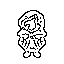

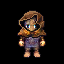

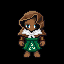

100%|██████████| 108/108 [00:01<00:00, 58.34it/s]


In [6]:
# -------- Evaluate with test dataset ------------

model, dataset = load_model_dataset(phase="test")
evaluate_model(model, dataset, phase="test")

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 64                            	[default: 256]
                 dataroot: ./pix2pix_data/AB             	[default: None]
             dataset_mode: aligned                       
                direction: BtoA                          	[default: AtoB]
          display_winsize: 64                            	[default: 256]
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
          

  0%|          | 0/795 [00:00<?, ?it/s]

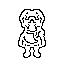

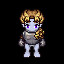

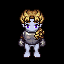

100%|██████████| 795/795 [00:12<00:00, 62.68it/s]


In [7]:
model, dataset = load_model_dataset(phase="train")
evaluate_model(model, dataset, phase="train")